In [1]:
import os
cwd = os.getcwd()
print(cwd)
if cwd[-9:] == 'NoteBooks' or cwd[-5:] in ['/ilc2', '/data']:
    try:
        # Move up to root folder
        os.chdir(".." + ('/..' if cwd[-5:] == '/ilc2' else ''))
        print(f"Directory changed: {os.getcwd()}")
    except OSError:
        print("Can't change the Current Working Directory") 
else:
    print("No need to change the Current Working Directory")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from glob import glob

In [4]:
import json
import os
from pathlib import Path

import pandas as pd
import numpy as np

from compute_f import split_ts_seq, compute_step_positions
from io_f import read_data_file
from visualize_f import visualize_trajectory, visualize_heatmap, save_figure_to_html

floor_data_dir = './data/ilc2/data/site1/F1'
path_data_dir = floor_data_dir + '/path_data_files'
floor_plan_filename = floor_data_dir + '/floor_image.png'
floor_info_filename = floor_data_dir + '/floor_info.json'

save_dir = './data/ilc2/output/site1/F1'
path_image_save_dir = save_dir + '/path_images'
step_position_image_save_dir = save_dir
magn_image_save_dir = save_dir
wifi_image_save_dir = save_dir + '/wifi_images'
ibeacon_image_save_dir = save_dir + '/ibeacon_images'
wifi_count_image_save_dir = save_dir

In [5]:
Path(path_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(magn_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(wifi_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(ibeacon_image_save_dir).mkdir(parents=True, exist_ok=True)

with open(floor_info_filename) as f:
    floor_info = json.load(f)
width_meter = floor_info["map_info"]["width"]
height_meter = floor_info["map_info"]["height"]

# Investigating a trace file

In [6]:
from tqdm.auto import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from integrations.ilc2 import get_input, json_points_to_array, collect_stats, get_filenames, collect_paths, visualize, load_stats, write_stats, group_paths, runner

In [7]:
FULL = False
WRITE_STATS = False

data_folder = "./data/ilc2/data/"
traces_folder = '/path_data_files'

if FULL:
    data_folder = "/Volumes/DD Romain/dataP3a/indoor-location-navigation/train"
    traces_folder = ''

stats_path = data_folder + '/stats.csv'

In [8]:
# Get path_filenames
# If write_stats -> collect them all
# Else, load write_stats and do filtering
if WRITE_STATS:
    path_filenames = []
    for floor in tqdm(glob(data_folder + '/*/*/')):
        path_filenames.extend(get_filenames(floor + traces_folder))
else:
    stats_df = load_stats(stats_path)
    # FILTERING BASED ON stats_df
    if not FULL:
        stats_df = stats_df[(stats_df.site == 'site1') & (stats_df.floor == 'F2')]
    # Filenames collection
    path_filenames = list(map(Path, stats_df['filepath']))

path_filenames

[PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F2/path_data_files/5dda5aed9191710006b573e7.txt'),
 PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F2/path_data_files/5dda402bc5b77e0006b176bd.txt'),
 PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F2/path_data_files/5dda5a99c5b77e0006b1770b.txt'),
 PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F2/path_data_files/5dda5263c5b77e0006b17705.txt'),
 PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F2/path_data_files/5dda402fc5b77e0006b176c1.txt'),
 PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F2/path_data_files/5dda520d9191710006b573b3.txt'),
 PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F2/path_data_files/5dda52659191710006b573cd.txt'),
 PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F2/path_data_files/5dda40389191710006b57390.txt'),
 PosixPath('/Users/romai

In [9]:
json_paths = collect_paths(path_filenames)

if WRITE_STATS:
    stats_dfs = []
    stats_dfs.append(collect_stats(json_paths))
    stats_df = pd.concat(stats_dfs)
    write_stats(stats_df, stats_path)

# stats_df has been loaded or computed (if WRITE_STATS == True)
df = stats_df.sort_values(by='nb_points', ascending=False)
df.describe()

  0%|          | 0/123 [00:00<?, ?it/s]

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

,Unnamed: 0,nb_points,timestep_dev,timestep_avg,speed_dev
count,123.000000,123.000000,123.000000,123.000000,123.000000
mean,753.000000,8.528455,0.331269,7608.921711,0.216766
std,35.651087,5.666012,0.140262,9902.412010,0.103970
min,692.000000,2.000000,0.000000,2558.333333,0.000000
25%,722.500000,5.000000,0.267030,4725.166667,0.149374
50%,753.000000,6.000000,0.355115,5892.250000,0.226876
75%,783.500000,11.000000,0.407200,7087.416667,0.289189
max,814.000000,27.000000,0.771450,75915.285714,0.529731


In [10]:
df.describe()

,Unnamed: 0,nb_points,timestep_dev,timestep_avg,speed_dev
count,123.000000,123.000000,123.000000,123.000000,123.000000
mean,753.000000,8.528455,0.331269,7608.921711,0.216766
std,35.651087,5.666012,0.140262,9902.412010,0.103970
min,692.000000,2.000000,0.000000,2558.333333,0.000000
25%,722.500000,5.000000,0.267030,4725.166667,0.149374
50%,753.000000,6.000000,0.355115,5892.250000,0.226876
75%,783.500000,11.000000,0.407200,7087.416667,0.289189
max,814.000000,27.000000,0.771450,75915.285714,0.529731


In [11]:
df.iloc[:50]

,Unnamed: 0,filepath,nb_points,timestep_dev,timestep_avg,speed_dev,site,floor,path_id
700,700,/Users/romainfouilland/code/cours/P3A/data/ilc...,27,0.486000,5787.769231,0.238200,site1,F2,5dda40219191710006b57384
747,747,/Users/romainfouilland/code/cours/P3A/data/ilc...,26,0.343336,6444.760000,0.296488,site1,F2,5dda51fb9191710006b573ad
699,699,/Users/romainfouilland/code/cours/P3A/data/ilc...,22,0.479760,6373.476190,0.182941,site1,F2,5dda40389191710006b57390
804,804,/Users/romainfouilland/code/cours/P3A/data/ilc...,21,0.367338,3948.400000,0.290142,site1,F2,5dda5b02c5b77e0006b17721
744,744,/Users/romainfouilland/code/cours/P3A/data/ilc...,21,0.314191,7513.850000,0.161998,site1,F2,5dda521e9191710006b573b9
732,732,/Users/romainfouilland/code/cours/P3A/data/ilc...,20,0.296872,8381.157895,0.269199,site1,F2,5dda5afcc5b77e0006b17719
716,716,/Users/romainfouilland/code/cours/P3A/data/ilc...,20,0.345963,7416.263158,0.226920,site1,F2,5dda5225c5b77e0006b176f3
736,736,/Users/romainfouilland/code/cours/P3A/data/ilc...,19,0.366539,7703.500000,0.170380,site1,F2,5dda5233c5b77e0006b176f7
749,749,/Users/romainfouilland/code/cours/P3A/data/ilc...,19,0.382478,7296.722222,0.199212,site1,F2,5dda040ac5b77e0006b1742a
809,809,/Users/romainfouilland/code/cours/P3A/data/ilc...,19,0.334540,5380.666667,0.288076,site1,F2,5dda5247c5b77e0006b176fb


array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'nb_points'}>],
       [<AxesSubplot:title={'center':'timestep_dev'}>,
        <AxesSubplot:title={'center':'timestep_avg'}>],
       [<AxesSubplot:title={'center':'speed_dev'}>, <AxesSubplot:>]],
      dtype=object)

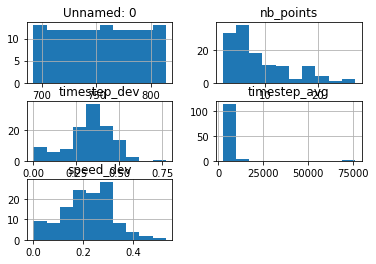

In [12]:
df.hist()

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'nb_points'}>],
       [<AxesSubplot:title={'center':'timestep_dev'}>,
        <AxesSubplot:title={'center':'timestep_avg'}>],
       [<AxesSubplot:title={'center':'speed_dev'}>, <AxesSubplot:>]],
      dtype=object)

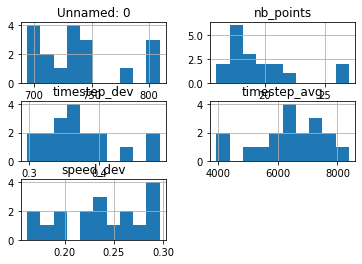

In [13]:
df[df['nb_points'] > 15].hist()

In [14]:
scores = pd.concat([
    df.groupby(['site', 'floor']).sum()['nb_points'],
    df.groupby(['site', 'floor'])[['timestep_avg', 'timestep_dev']].mean(),
    df.groupby(['site', 'floor']).size().rename('size')
], axis=1)
scores[scores['nb_points'] > 500].sort_values(
    'size', ascending=False
    # 'timestep_dev'
).head(50)

,,nb_points,timestep_avg,timestep_dev,size
site,floor,,,,
site1,F2,1049,7608.921711,0.331269,123


,Unnamed: 0,filepath,nb_points,timestep_dev,timestep_avg,speed_dev,site,floor,path_id
747,747,/Users/romainfouilland/code/cours/P3A/data/ilc...,26,0.343336,6444.760000,0.296488,site1,F2,5dda51fb9191710006b573ad
804,804,/Users/romainfouilland/code/cours/P3A/data/ilc...,21,0.367338,3948.400000,0.290142,site1,F2,5dda5b02c5b77e0006b17721
744,744,/Users/romainfouilland/code/cours/P3A/data/ilc...,21,0.314191,7513.850000,0.161998,site1,F2,5dda521e9191710006b573b9
732,732,/Users/romainfouilland/code/cours/P3A/data/ilc...,20,0.296872,8381.157895,0.269199,site1,F2,5dda5afcc5b77e0006b17719
716,716,/Users/romainfouilland/code/cours/P3A/data/ilc...,20,0.345963,7416.263158,0.226920,site1,F2,5dda5225c5b77e0006b176f3
736,736,/Users/romainfouilland/code/cours/P3A/data/ilc...,19,0.366539,7703.500000,0.170380,site1,F2,5dda5233c5b77e0006b176f7
749,749,/Users/romainfouilland/code/cours/P3A/data/ilc...,19,0.382478,7296.722222,0.199212,site1,F2,5dda040ac5b77e0006b1742a
809,809,/Users/romainfouilland/code/cours/P3A/data/ilc...,19,0.334540,5380.666667,0.288076,site1,F2,5dda5247c5b77e0006b176fb
779,779,/Users/romainfouilland/code/cours/P3A/data/ilc...,18,0.337274,5002.235294,0.256885,site1,F2,5dda5a8b9191710006b573da
711,711,/Users/romainfouilland/code/cours/P3A/data/ilc...,18,0.394476,6100.941176,0.253899,site1,F2,5dda5214c5b77e0006b176ef


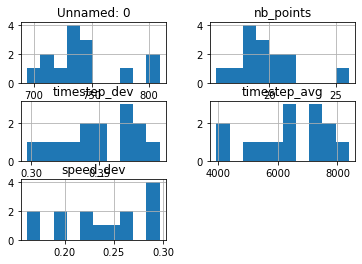

In [15]:
filtered_df = df[(df['nb_points'] > 15) & (df['timestep_dev'] < 0.4) & (df['timestep_avg'] < 10000)]
filtered_df.hist()
filtered_df

In [16]:
filtered_df.groupby(['site', 'floor']).size()

site   floor
site1  F2       14
dtype: int64

In [17]:
filtered_df.groupby(['site', 'floor']).size().idxmax(), filtered_df.groupby(['site', 'floor']).size().max()

(('site1', 'F2'), 14)

,Unnamed: 0,filepath,nb_points,timestep_dev,timestep_avg,speed_dev,site,floor,path_id
747,747,/Users/romainfouilland/code/cours/P3A/data/ilc...,26,0.343336,6444.760000,0.296488,site1,F2,5dda51fb9191710006b573ad
804,804,/Users/romainfouilland/code/cours/P3A/data/ilc...,21,0.367338,3948.400000,0.290142,site1,F2,5dda5b02c5b77e0006b17721
744,744,/Users/romainfouilland/code/cours/P3A/data/ilc...,21,0.314191,7513.850000,0.161998,site1,F2,5dda521e9191710006b573b9
732,732,/Users/romainfouilland/code/cours/P3A/data/ilc...,20,0.296872,8381.157895,0.269199,site1,F2,5dda5afcc5b77e0006b17719
716,716,/Users/romainfouilland/code/cours/P3A/data/ilc...,20,0.345963,7416.263158,0.226920,site1,F2,5dda5225c5b77e0006b176f3
736,736,/Users/romainfouilland/code/cours/P3A/data/ilc...,19,0.366539,7703.500000,0.170380,site1,F2,5dda5233c5b77e0006b176f7
749,749,/Users/romainfouilland/code/cours/P3A/data/ilc...,19,0.382478,7296.722222,0.199212,site1,F2,5dda040ac5b77e0006b1742a
809,809,/Users/romainfouilland/code/cours/P3A/data/ilc...,19,0.334540,5380.666667,0.288076,site1,F2,5dda5247c5b77e0006b176fb
779,779,/Users/romainfouilland/code/cours/P3A/data/ilc...,18,0.337274,5002.235294,0.256885,site1,F2,5dda5a8b9191710006b573da
711,711,/Users/romainfouilland/code/cours/P3A/data/ilc...,18,0.394476,6100.941176,0.253899,site1,F2,5dda5214c5b77e0006b176ef


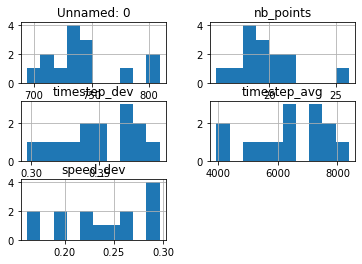

In [18]:
# site, floor = 'site1', 'F2'
site, floor = filtered_df.groupby(['site', 'floor']).size().idxmax()
final_df = filtered_df[(filtered_df['site'] == site) & (filtered_df['floor'] == floor)]
final_df.hist()
final_df

In [19]:
final_df['nb_points'].sum(), (final_df['nb_points'] * final_df['timestep_avg']).sum() // 1000 / 60

(270, 28.9)

In [20]:
if FULL:
    floor_plan_filename = f"/Volumes/DD Romain/dataP3a/indoor-location-navigation/metadata/{site}/{floor}/floor_image.png"
    floor_info_filename = f"/Volumes/DD Romain/dataP3a/indoor-location-navigation/metadata/{site}/{floor}/floor_info.json"
    print(floor_plan_filename)
else:
    floor_plan_filename = floor_data_dir + '/floor_image.png'
    floor_info_filename = floor_data_dir + '/floor_info.json'
    
with open(floor_info_filename) as f:
    floor_info = json.load(f)
width_meter = floor_info["map_info"]["width"]
height_meter = floor_info["map_info"]["height"]

# Building figs
figs = []
for _, row in tqdm(final_df.iterrows()):
    figs.append(visualize(
        row['filepath'], floor_plan_filename, width_meter, height_meter, 
        show=False
    ))

0it [00:00, ?it/s]

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.


In [21]:
@interact(
    i=widgets.IntSlider(min=0, max=len(figs) - 1, step=1, value=5)
)
def show_path(i):
    print(final_df.iloc[i])
    print(get_input(
        final_df.iloc[i].filepath,
        1,
        1
    ))
    figs[i].show()

interactive(children=(IntSlider(value=5, description='i', max=13), Output()), _dom_classes=('widget-interact',…

Loading points into DB: 100%|██████████████████████████████████████████████████████████| 1049/1049 [00:00<00:00, 152649.79it/s]


STARTING LOGIC
9.72%:  [0, 0, 0, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 13, 13, 13, 13, 14, 14, 16, 16, 16, 16, 16, 18, 18, 18, 20, 20, 22, 22, 22, 22, 22, 22, 25, 33, 40, 50]

RECURSION 1



Building update structures: 0it [00:00, ?it/s]
Building nm.one_pos: 0it [00:00, ?it/s]
Time steps: 100%|███████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 987.65it/s]


Loop times {'algo': 0.6646499633789062, 'update': 0.006392002105712891}
Recursion 0 updated 0 alone and 0 one pos points (for a total of 0) with speed of 2.0.

RECURSION 2



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1128.65it/s]


Loop times {'algo': 0.584111213684082, 'update': 0.1485157012939453}
Recursion 1 updated 1536 alone and 395 one pos points (for a total of 1931) with speed of 1.8000000000000003.

RECURSION 3



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1144.51it/s]


Loop times {'algo': 0.5762360095977783, 'update': 0.15376901626586914}
Recursion 2 updated 742 alone and 192 one pos points (for a total of 2865) with speed of 1.62.

RECURSION 4



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1095.53it/s]


Loop times {'algo': 0.6016020774841309, 'update': 0.13567781448364258}
Recursion 3 updated 438 alone and 66 one pos points (for a total of 3369) with speed of 1.4580000000000002.

RECURSION 5



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1285.04it/s]


Loop times {'algo': 0.5134739875793457, 'update': 0.13916540145874023}
Recursion 4 updated 268 alone and 75 one pos points (for a total of 3712) with speed of 1.3122.

RECURSION 6



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1412.53it/s]


Loop times {'algo': 0.4676480293273926, 'update': 0.13643097877502441}
Recursion 5 updated 154 alone and 18 one pos points (for a total of 3884) with speed of 1.1809800000000001.

RECURSION 7



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1423.98it/s]


Loop times {'algo': 0.4638047218322754, 'update': 0.13494420051574707}
Recursion 6 updated 67 alone and 6 one pos points (for a total of 3957) with speed of 1.062882.

RECURSION 8



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1402.67it/s]


Loop times {'algo': 0.4709889888763428, 'update': 0.13089203834533691}
Recursion 7 updated 32 alone and 0 one pos points (for a total of 3989) with speed of 0.9565938.

RECURSION 9



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1385.10it/s]


Loop times {'algo': 0.47661304473876953, 'update': 0.13222312927246094}
Recursion 8 updated 0 alone and 0 one pos points (for a total of 3989) with speed of 0.86093442.

RECURSION 10



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1348.81it/s]


Loop times {'algo': 0.48932790756225586, 'update': 0.13134217262268066}
Recursion 9 updated 15 alone and 0 one pos points (for a total of 4004) with speed of 0.7748409780000001.

RECURSION 11



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1384.72it/s]


Loop times {'algo': 0.47683286666870117, 'update': 0.13221192359924316}
Recursion 10 updated 38 alone and 0 one pos points (for a total of 4042) with speed of 0.6973568802.

RECURSION 12



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1342.35it/s]


Loop times {'algo': 0.49167418479919434, 'update': 0.13126778602600098}
Recursion 11 updated 6 alone and 0 one pos points (for a total of 4048) with speed of 0.6276211921800001.

RECURSION 13



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1344.47it/s]


Loop times {'algo': 0.49093008041381836, 'update': 0.1304328441619873}
Recursion 12 updated 2 alone and 0 one pos points (for a total of 4050) with speed of 0.5648590729620001.

RECURSION 14



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1164.93it/s]


Loop times {'algo': 0.5661158561706543, 'update': 0.1358950138092041}
Recursion 13 updated 6 alone and 0 one pos points (for a total of 4056) with speed of 0.5083731656658.

RECURSION 15



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1299.55it/s]


Loop times {'algo': 0.5076007843017578, 'update': 0.13416719436645508}
Recursion 14 updated 0 alone and 0 one pos points (for a total of 4056) with speed of 0.45753584909922007.

RECURSION 16



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1280.64it/s]


Loop times {'algo': 0.5152208805084229, 'update': 0.13696002960205078}
Recursion 15 updated 0 alone and 0 one pos points (for a total of 4056) with speed of 0.41178226418929814.

RECURSION 17



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1272.36it/s]


Loop times {'algo': 0.518470048904419, 'update': 0.13078784942626953}
Recursion 16 updated 0 alone and 0 one pos points (for a total of 4056) with speed of 0.3706040377703683.

RECURSION 18



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1308.54it/s]


Loop times {'algo': 0.5048391819000244, 'update': 0.1344127655029297}
Recursion 17 updated 0 alone and 0 one pos points (for a total of 4056) with speed of 0.33354363399333153.

RECURSION 19



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1289.36it/s]


Loop times {'algo': 0.5117590427398682, 'update': 0.1273021697998047}
Recursion 18 updated 0 alone and 0 one pos points (for a total of 4056) with speed of 0.3001892705939984.
74.44%:  [0, 0, 0, 4, 5, 6, 7, 8, 9, 9, 9, 10, 11, 13, 18, 22, 22, 28, 29, 32, 32, 33, 33, 35, 40, 40, 43, 44, 50, 50, 56, 57, 58, 59, 61, 61, 62, 62, 63, 63, 66, 66, 67, 70, 73, 73, 75, 78, 78, 80, 81, 82, 85, 87, 88, 90, 90, 91, 91, 93, 95, 95, 96, 96, 97, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

RECURSION 1



Building update structures: 0it [00:00, ?it/s]
Building nm.one_pos: 0it [00:00, ?it/s]
Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1063.76it/s]


Loop times {'algo': 0.6173980236053467, 'update': 0.011413812637329102}
Recursion 0 updated 0 alone and 0 one pos points (for a total of 0) with speed of 2.0.

RECURSION 2



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1211.47it/s]


Loop times {'algo': 0.5448954105377197, 'update': 0.1583538055419922}
Recursion 1 updated 127 alone and 0 one pos points (for a total of 127) with speed of 1.8000000000000003.

RECURSION 3



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1325.36it/s]


Loop times {'algo': 0.498018741607666, 'update': 0.1405491828918457}
Recursion 2 updated 8 alone and 0 one pos points (for a total of 135) with speed of 1.62.

RECURSION 4



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1325.60it/s]


Loop times {'algo': 0.4982788562774658, 'update': 0.13873291015625}
Recursion 3 updated 0 alone and 0 one pos points (for a total of 135) with speed of 1.4580000000000002.

RECURSION 5



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1331.74it/s]


Loop times {'algo': 0.49577903747558594, 'update': 0.13564276695251465}
Recursion 4 updated 16 alone and 0 one pos points (for a total of 151) with speed of 1.3122.

RECURSION 6



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1312.11it/s]


Loop times {'algo': 0.5034120082855225, 'update': 0.136275053024292}
Recursion 5 updated 0 alone and 0 one pos points (for a total of 151) with speed of 1.1809800000000001.

RECURSION 7



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1319.12it/s]


Loop times {'algo': 0.5007281303405762, 'update': 0.13341879844665527}
Recursion 6 updated 0 alone and 0 one pos points (for a total of 151) with speed of 1.062882.

RECURSION 8



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1258.44it/s]


Loop times {'algo': 0.5247490406036377, 'update': 0.13306903839111328}
Recursion 7 updated 0 alone and 0 one pos points (for a total of 151) with speed of 0.9565938.

RECURSION 9



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1368.28it/s]


Loop times {'algo': 0.48274874687194824, 'update': 0.13068222999572754}
Recursion 8 updated 0 alone and 0 one pos points (for a total of 151) with speed of 0.86093442.

RECURSION 10



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1311.95it/s]


Loop times {'algo': 0.5036618709564209, 'update': 0.1371612548828125}
Recursion 9 updated 0 alone and 0 one pos points (for a total of 151) with speed of 0.7748409780000001.

RECURSION 11



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1366.41it/s]


Loop times {'algo': 0.4831860065460205, 'update': 0.13229990005493164}
Recursion 10 updated 0 alone and 0 one pos points (for a total of 151) with speed of 0.6973568802.

RECURSION 12



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1371.26it/s]


Loop times {'algo': 0.481766939163208, 'update': 0.13312482833862305}
Recursion 11 updated 0 alone and 0 one pos points (for a total of 151) with speed of 0.6276211921800001.

RECURSION 13



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1357.93it/s]


Loop times {'algo': 0.4864230155944824, 'update': 0.1363818645477295}
Recursion 12 updated 0 alone and 0 one pos points (for a total of 151) with speed of 0.5648590729620001.

RECURSION 14



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1233.67it/s]


Loop times {'algo': 0.5350782871246338, 'update': 0.1294999122619629}
Recursion 13 updated 3 alone and 0 one pos points (for a total of 154) with speed of 0.5083731656658.

RECURSION 15



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1369.29it/s]


Loop times {'algo': 0.48207998275756836, 'update': 0.13104629516601562}
Recursion 14 updated 0 alone and 0 one pos points (for a total of 154) with speed of 0.45753584909922007.

RECURSION 16



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1372.38it/s]


Loop times {'algo': 0.48134589195251465, 'update': 0.13497018814086914}
Recursion 15 updated 0 alone and 0 one pos points (for a total of 154) with speed of 0.41178226418929814.

RECURSION 17



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1371.67it/s]


Loop times {'algo': 0.48161888122558594, 'update': 0.1339409351348877}
Recursion 16 updated 0 alone and 0 one pos points (for a total of 154) with speed of 0.3706040377703683.

RECURSION 18



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1336.97it/s]


Loop times {'algo': 0.49390268325805664, 'update': 0.13392424583435059}
Recursion 17 updated 0 alone and 0 one pos points (for a total of 154) with speed of 0.33354363399333153.

RECURSION 19



Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1379.79it/s]


Loop times {'algo': 0.47939491271972656, 'update': 0.13974213600158691}
Recursion 18 updated 0 alone and 0 one pos points (for a total of 154) with speed of 0.3001892705939984.

FINAL RECURSION



Building update structures: 0it [00:00, ?it/s]
Building nm.one_pos: 0it [00:00, ?it/s]
Time steps: 100%|██████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 1314.31it/s]


Loop times {'algo': 0.5001230239868164, 'update': 0.0073850154876708984}
Final recursion updated 0 alone and 0 one pos points with speed of 2.0.
77.98%:  [0, 0, 0, 4, 5, 6, 8, 9, 9, 9, 10, 11, 18, 22, 28, 32, 32, 33, 33, 40, 40, 43, 44, 50, 50, 51, 57, 57, 58, 59, 61, 61, 62, 62, 63, 66, 66, 67, 70, 73, 78, 78, 81, 82, 85, 85, 87, 88, 90, 90, 91, 91, 93, 95, 95, 96, 96, 96, 97, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Done




Displaying DB: 100%|█████████████████████████████████████████████████████████████████████████| 655/655 [01:42<00:00,  6.40it/s]


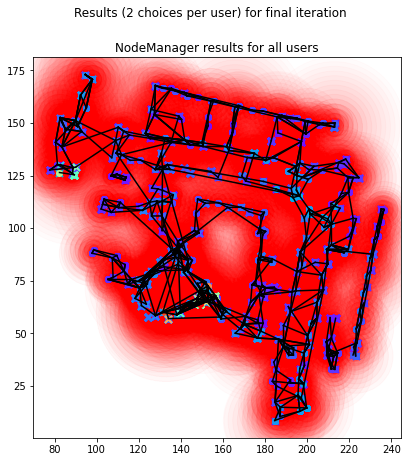

In [22]:
 nm = runner(
    group_paths(json_paths),
    creation=True, max_creation=15,  # allow creation of points if no matching onex
    max_speed=2,
    analyze_input=False, show=False, final_plot=True
)

# Conclusion & question
## Pipeline
- We collect traces with ILC2 module **(done)**
- We convert them to a manageable format
    - 1. Convert them to .json path to be injected in the solution with the API integration **(done)**
    - 2. Convert them to .plt Geolife format (integrations/helper.py > to_plt) -> if we are willing to round all times to the closest second
- We compute stats
    - 1. Compute stats on them and store all of them in a stats file to be able to do easy filtering (just like Geolife with .plt -> stats -> filters -> loaded traces) -> can compute stats when we convert them and include them in the json -> better to build stats on json as this could be reused later (API json format) -> but OK to write them back in the json directly too **(computation done | storage left)**
    - 2. Directly leverage .plt filtering pipeline **(just implement filter functions)**
- We agregate traces
    - We need same site + floor + timestep_avg (to be used as dt unless we are willing to scale a bit -> change the speed to keep the same positions in the building)
    - Aggregate them to use the same t0 and same dt and max(tf)
    
## Data
- How should we decide on bluetooth / camera points and camera traces ? Traces are short so perhaps we can do only beginning and end as bluetooth and rest as camera points with no trace. But seems a bit hard.
- How to deal with non-periodic recording times?
- What do we want to prove with the experiments?
- Build an ICL2 object to collect initial data, build fig, stats, ... and also reconciliation function which will return the final API json data?